In [206]:
from yolo.data import CollateWithAnchors, CocoDataset, get_val_transforms
from yolo.visualize import render_bounding_boxes, plot
import itertools
from PIL import Image
from torchvision import tv_tensors
from torchvision.ops import box_convert
from torchvision.transforms.v2.functional import convert_bounding_box_format


from yolo.anchors import (
    make_spatial_anchors,
    make_scale_map,
    make_anchor_map,
    make_spatial_anchor_mask,
    encode_boxes,
    DecodeBoxes
)

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
from typing import List, Tuple

def make_cxcy_map(
    scales: List[int],
    image_height: int,
    image_width: int,
    num_anchors_per_scale: int = 3,
):
    cxcy_map_list = []
    for scale in scales:
        scaled_height = int(image_height / scale)
        scaled_width = int(image_width / scale)
        
        x_axis = torch.arange(scaled_width)
        y_axis = torch.arange(scaled_height)
        grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij")  # .shape [13,19]
        grid_xy = torch.stack([grid_x, grid_y], dim=-1)  # .shape [13, 19, 2]
        grid_xy_expanded = grid_xy.unsqueeze(2)
        grid_xy_copied = grid_xy_expanded.expand(*grid_xy.shape[:2], num_anchors_per_scale, 2)
        grid_xy_flat = grid_xy_copied.flatten(end_dim=-2)
        cxcy_map_list.append(grid_xy_flat)
    cxcy_map = torch.cat(cxcy_map_list, axis=0)
    return cxcy_map


In [171]:
IMAGE_SIZE = 608
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32]

val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "validation",
    transform = get_val_transforms(resize_size=IMAGE_SIZE)
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=CollateWithAnchors(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE, num_classes = val_dataset.num_classes())
)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [172]:
batch = next(iter(val_dataloader))

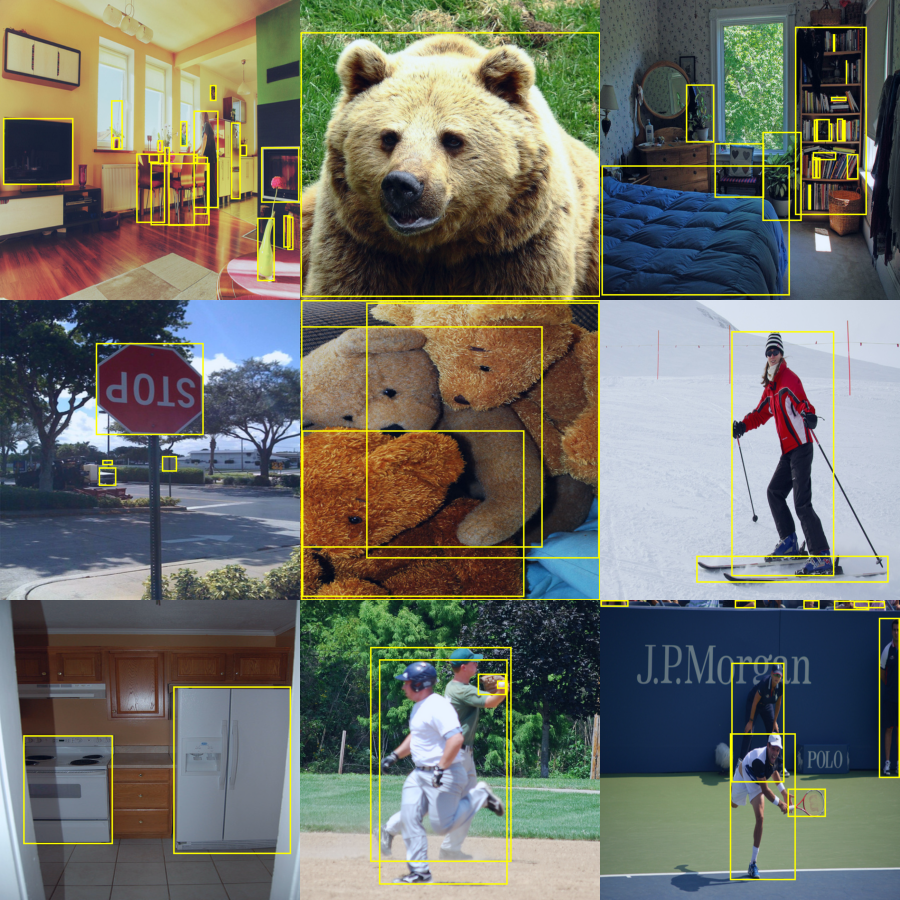

In [173]:
def flatten_batch(batch):
    keys = [k for k in batch.keys() if k != "image"]
    images = batch["image"]
    flat = []
    for i in range(len(images)):
        flat.append((images[i], {key: batch[key][i] for key in keys}))
    return flat

batch_flat = flatten_batch(batch)[:9]
batch_flat_reshape = [list(x) for x in itertools.batched(batch_flat, 3)]
vis = plot(batch_flat_reshape)
Image.fromarray(vis)

In [174]:
box_decoder = DecodeBoxes(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE)
coord_bxbybwbh = box_decoder(batch["coordinates_label"])

In [180]:
num_boxes = sum([b.shape[0] for b in batch["boxes"]])
num_boxes

81

In [192]:
binary_mask = batch["objectness_label"].bool()

In [193]:
non_zero_bxbybwbh = [coord_bxbybwbh[i][binary_mask[i].squeeze()] for i in range(coord_bxbybwbh.shape[0])]

In [199]:
sum([b.shape[0] for b in non_zero_bxbybwbh])

81

In [209]:
non_zero_boxes = [tv_tensors.BoundingBoxes(
    box,
    format="XYWH",
    canvas_size=(IMAGE_SIZE, IMAGE_SIZE)) for box in non_zero_bxbybwbh]
non_zero_boxes = [convert_bounding_box_format(x, new_format= tv_tensors.BoundingBoxFormat.XYXY) for x in non_zero_boxes]

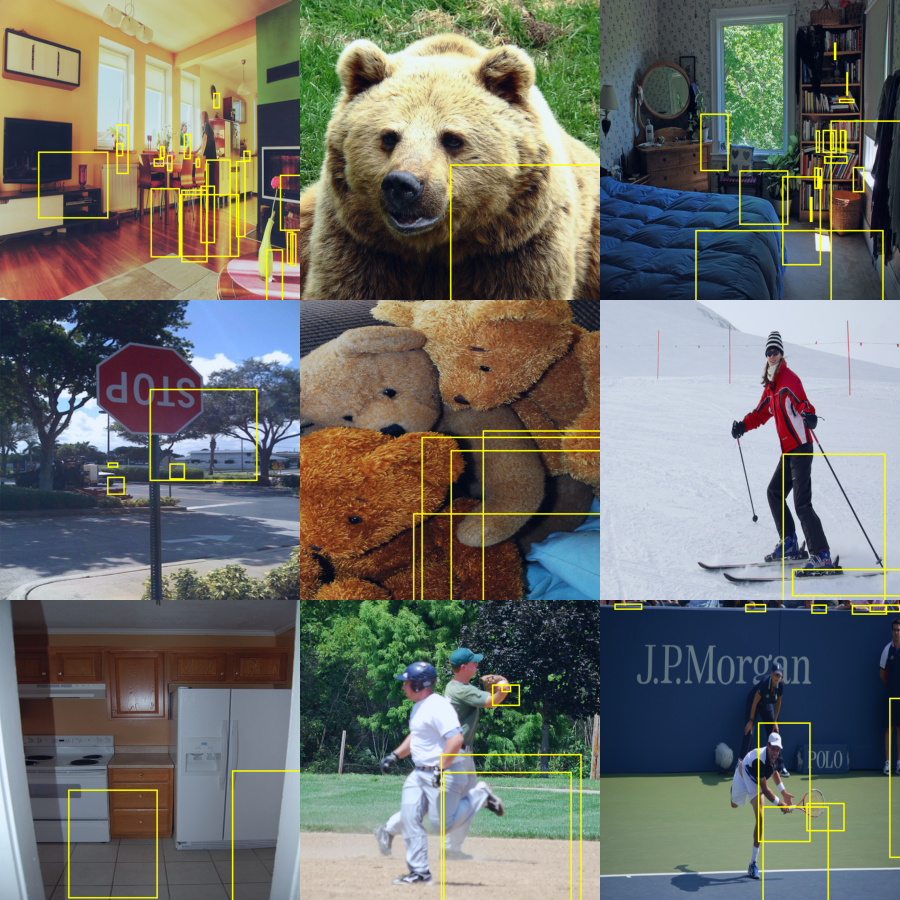

In [211]:
vis_tuples = [(image, {"boxes": boxes}) for image,boxes in zip(batch["image"], non_zero_boxes)][:9]
vis_tuples = [list(x) for x in itertools.batched(vis_tuples, 3)]
vis = plot(vis_tuples)
Image.fromarray(vis)